<a href="https://colab.research.google.com/github/laritrevilato/fake_news_classification/blob/main/TCC_Larissa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade nltk
!pip install --upgrade numpy
!pip install --upgrade gensim
!pip install --upgrade pandas
!pip install --upgrade scipy
!pip install --upgrade scikit-learn
!pip install matplotlib
!pip install git-python

#scikit-learn

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached nu

In [2]:
from nltk.tokenize import word_tokenize
import scipy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import nltk
import git


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
repo_dir_Fakebr = "/content/repo/Fakebr"
repo_Fakebr = "https://github.com/roneysco/Fake.br-Corpus.git"
diretorio_verdadeiras_Fakebr = "/content/repo/Fakebr/full_texts/true"
diretorio_falsas_Fakebr = "/content/repo/Fakebr/full_texts/fake"

repo_dir_FakeRecogna = "/content/repo/FakeRecogna"
repo_FakeRecogna = "https://github.com/Gabriel-Lino-Garcia/FakeRecogna.git"
file_name_FakeRecogna = 'repo/FakeRecogna/dataset/FakeRecogna.xlsx'

repo_dir_FakeTrue = "/content/repo/FakeTrue"
repo_FakeTrue = "https://github.com/jpchav98/FakeTrue.Br.git"
file_name_FakeTrue = '/content/repo/FakeTrue/FakeTrueBr_corpus.csv'

repo_dir_BoatosBR = "/content/repo/BoatosBR"
repo_BoatosBR =  "https://github.com/Felipe-Harrison/boatos-br-corpus.git"


In [4]:
if not os.path.exists(repo_dir_Fakebr):
  git.Repo.clone_from(repo_Fakebr,repo_dir_Fakebr)

if not os.path.exists(repo_dir_FakeRecogna):
  git.Repo.clone_from(repo_FakeRecogna,repo_dir_FakeRecogna)

if not os.path.exists(repo_dir_FakeTrue):
  git.Repo.clone_from(repo_FakeTrue,repo_dir_FakeTrue)

if not os.path.exists(repo_dir_BoatosBR):
  git.Repo.clone_from(repo_BoatosBR,repo_dir_BoatosBR)

In [5]:
def pre_processamento(texto):

  tokens = word_tokenize(texto)

  tokens = [token.lower() for token in tokens]

  stop_words = set(stopwords.words('portuguese'))
  tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return ' '.join(tokens)

In [6]:
def read_FakeRecogna():

  df_FakeRecogna_raw = pd.read_excel(file_name_FakeRecogna)
  df_FakeRecogna_raw = df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia', 'Classe']]

  # Convert the columns to strings before joining
  df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia']] = df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia']].astype(str)

  # Replace non-finite values with a suitable integer (e.g., -1)
  df_FakeRecogna_raw['Classe'] = df_FakeRecogna_raw['Classe'].fillna(-1).astype(int)

  df_FakeRecogna = pd.DataFrame({
      'FullText': df_FakeRecogna_raw[['Titulo', 'Subtitulo', 'Noticia']].agg(' '.join, axis=1),
      'Classe': df_FakeRecogna_raw['Classe']
  })

  df_FakeRecogna['FullText'] = df_FakeRecogna['FullText'].apply(pre_processamento)

  df_FakeRecogna_true = df_FakeRecogna[df_FakeRecogna['Classe'] == 1].copy()
  df_FakeRecogna_fake = df_FakeRecogna[df_FakeRecogna['Classe'] == 0].copy()

  return df_FakeRecogna_true, df_FakeRecogna_fake

In [7]:
def read_Fakebr():
  noticias_verdadeiras = []
  noticias_falsas = []

  for arquivo in os.listdir(diretorio_verdadeiras_Fakebr):
    with open(os.path.join(diretorio_verdadeiras_Fakebr, arquivo), 'r', encoding='utf-8') as f:
      texto = f.read()
      texto_processado = pre_processamento(texto)
      noticias_verdadeiras.append((texto_processado,1))

  for arquivo in os.listdir(diretorio_falsas_Fakebr):
    with open(os.path.join(diretorio_falsas_Fakebr, arquivo), 'r', encoding='utf-8') as f:
      texto = f.read()
      texto_processado = pre_processamento(texto)
      noticias_falsas.append((texto_processado,0))

  df_Fakebr_true = pd.DataFrame(noticias_verdadeiras, columns=['FullText', 'Classe'])
  df_Fakebr_fake = pd.DataFrame(noticias_falsas, columns=['FullText', 'Classe'])

  return df_Fakebr_true, df_Fakebr_fake

In [8]:
def read_FakeTrue():

  df_FakeTrue_raw = pd.read_csv(file_name_FakeTrue)

  # Convert the columns to strings before joining
  df_FakeTrue_raw[['title_fake', 'fake', 'true']] = df_FakeTrue_raw[['title_fake', 'fake', 'true']].astype(str)

  df_FakeTrue = pd.DataFrame({
      'Fake': df_FakeTrue_raw[['title_fake', 'fake']].agg(' '.join, axis=1),
      'True': df_FakeTrue_raw['true']
  })

  df_FakeTrue['Fake'] = df_FakeTrue['Fake'].apply(pre_processamento)
  df_FakeTrue['True'] = df_FakeTrue['True'].apply(pre_processamento)

  df_FakeTrue_true = pd.DataFrame({
      'FullText': df_FakeTrue['True'],
      'Classe': 1
  })

  df_FakeTrue_fake = pd.DataFrame({
      'FullText': df_FakeTrue['Fake'],
      'Classe': 0
  })
  return df_FakeTrue_true, df_FakeTrue_fake

In [9]:
def read_BoatosBR():
  file_name_BoatosBR = "/content/repo/BoatosBR/base_simples/boatos_br_corpus_simples.json"

  df_BoatosBR_raw = pd.read_json(file_name_BoatosBR)
  df_BoatosBR_raw = df_BoatosBR_raw[['texto','rotulo']]

  df_BoatosBR_true = df_BoatosBR_raw[df_BoatosBR_raw['rotulo'] == 'verdade'].copy()
  df_BoatosBR_fake = df_BoatosBR_raw[df_BoatosBR_raw['rotulo'] == 'falso'].copy()

  df_BoatosBR_true['texto'] = df_BoatosBR_true['texto'].apply(pre_processamento)
  df_BoatosBR_fake['texto'] = df_BoatosBR_fake['texto'].apply(pre_processamento)

  df_BoatosBR_true = pd.DataFrame({
      'FullText': df_BoatosBR_true['texto'],
      'Classe': 1
  })

  df_BoatosBR_fake = pd.DataFrame({
      'FullText': df_BoatosBR_fake['texto'],
      'Classe': 0
  })

  return df_BoatosBR_true, df_BoatosBR_fake


In [10]:
def BOW(noticias):

  lista_noticias = noticias['FullText']
  lista_rotulos = noticias['Classe']

  vectorizer = CountVectorizer()
  matriz_bow = vectorizer.fit_transform(lista_noticias)

  return matriz_bow, lista_rotulos

In [11]:
#TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfTransformer

def TFIDF(noticias):

    # Step 1: Extract the text and labels
    texts = noticias['FullText'].astype(str).tolist()
    labels = noticias['Classe'].tolist()

    # Step 2: Convert text to a count matrix
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(texts)

    # Step 3: Apply TF-IDF transformation
    transformer = TfidfTransformer()
    tfidf_matrix = transformer.fit_transform(count_matrix)

    return tfidf_matrix, labels

In [12]:
#Word2Vec

import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def function_Word2Vec(noticias):

    vector_size=300
    window=10
    min_count=5

    # Step 1: Preprocess text
    noticias['FullText'] = noticias['FullText'].astype(str).str.lower()
    tokenized_texts = noticias['FullText'].apply(word_tokenize).tolist()

    # Step 2: Train Word2Vec model
    w2v_model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4
    )

    # Step 5: Compute document vectors (average of word vectors)
    def document_vector(doc):
        vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(vector_size)

    doc_vectors = np.array([document_vector(doc) for doc in tokenized_texts])

    # Apply MinMaxScaler to normalize document vectors
    scaler = MinMaxScaler()
    doc_vectors_normalized = scaler.fit_transform(doc_vectors)

    labels = noticias['Classe'].tolist()

    return doc_vectors, labels


In [ ]:
#df_FakeRecogna_true  --5951
#df_FakeRecogna_fake  --5951

#df_Fakebr_true       --3600
#df_Fakebr_fake       --3600

#df_FakeTrue_true     --1791
#df_FakeTrue_fake     --1791

#df_BoatosBR_true     --1516
#df_BoatosBR_fake     --1906 -- 1516

#full_data            --25716

In [13]:
def function_SVC(bow_treino, rotulos_treino, bow_teste, rotulos_teste):

    from sklearn.svm import SVC

    # Create an SVC model
    model = SVC(kernel='linear', C=1.0)

    # Fit the model to the training data
    model.fit(bow_treino, rotulos_treino)

    # Make predictions on the test set
    y_pred = model.predict(bow_teste)

    # Evaluate the model's performance
    accuracy = accuracy_score(rotulos_teste, y_pred)
    #print(f'Accuracy: {accuracy:.2f}')

    return accuracy

In [14]:
def function_LogisticRegression(bow_treino, rotulos_treino, bow_teste, rotulos_teste):
    from sklearn.linear_model import LogisticRegression

    # Create a Logistic Regression model
    model = LogisticRegression(max_iter=200)  # Increase max_iter if needed

    # Fit the model to the training data
    model.fit(bow_treino, rotulos_treino)

    # Make predictions on the test set
    y_pred = model.predict(bow_teste)

    # Evaluate the model's performance
    accuracy = accuracy_score(rotulos_teste, y_pred)
    #print(f'Accuracy: {accuracy:.2f}')

    return accuracy


In [15]:
def function_MultinomialNB(bow_treino, rotulos_treino, bow_teste, rotulos_teste):

    from sklearn.naive_bayes import MultinomialNB

    # Create a Multinomial Naive Bayes model
    model = MultinomialNB(alpha=1.0)  # Default alpha is 1.0

    # Fit the model to the training data
    model.fit(bow_treino, rotulos_treino)

    # Make predictions on the test set
    y_pred = model.predict(bow_teste)

    # Evaluate the model's performance
    accuracy = accuracy_score(rotulos_teste, y_pred)
    # print(f'Accuracy: {accuracy:.2f}')

    return accuracy

In [16]:
df_FakeRecogna_true, df_FakeRecogna_fake = read_FakeRecogna()

In [17]:
df_Fakebr_true, df_Fakebr_fake = read_Fakebr()

In [18]:
df_FakeTrue_true, df_FakeTrue_fake = read_FakeTrue()

In [19]:
df_BoatosBR_true, df_BoatosBR_fake = read_BoatosBR()
df_BoatosBR_fake = df_BoatosBR_fake.sample(n=1516, random_state=42).reset_index(drop=True)

In [20]:
def representation_method(method_name, dataframe):
    method_map = {
        'BOW': BOW,
        'TFIDF': TFIDF,
        'function_Word2Vec': function_Word2Vec
    }

    if method_name not in method_map:
        raise ValueError(f"Unknown method: {method_name}")

    # Call the appropriate function
    return method_map[method_name](dataframe)

In [21]:
def process_classification_methods(representation, dataframe):

    bow_completa, rotulos_completos = representation_method(representation, dataframe)

    bow_treino, bow_teste, rotulos_treino, rotulos_teste = train_test_split(
        bow_completa,
        rotulos_completos,
        test_size=0.2,
        random_state=52,
        stratify=rotulos_completos
    )

    accuracy_SVC = function_SVC(bow_treino, rotulos_treino, bow_teste, rotulos_teste)
    accuracy_LR = function_LogisticRegression(bow_treino, rotulos_treino, bow_teste, rotulos_teste)
    #accuracy_MNB = function_MultinomialNB(bow_treino, rotulos_treino, bow_teste, rotulos_teste)

    return [accuracy_SVC, accuracy_LR]

In [ ]:
def plot_model_comparison(
    results,
    representation_name,
    model_names,
    dataset_labels = None
):

    import matplotlib.pyplot as plt
    import numpy as np

    if dataset_labels is None:
      dataset_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5']

    # Bar positions
    x = np.arange(len(model_names))
    width = 0.15  # width of the bars

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - 2*width, results[0], width, label=dataset_labels[0], color='lightcoral')
    bars2 = ax.bar(x - width, results[1], width, label=dataset_labels[1], color='cornflowerblue')
    bars3 = ax.bar(x, results[2], width, label=dataset_labels[2], color='turquoise')
    bars4 = ax.bar(x + width, results[3], width, label=dataset_labels[3], color='mediumpurple')
    bars5 = ax.bar(x + 2*width, results[4], width, label=dataset_labels[4], color='dodgerblue')

    # Labels and formatting
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Model Accuracy: {representation_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1.05)
    ax.legend()

    # Add accuracy values above bars
    for bars in [bars1, bars2, bars3, bars4, bars5]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


In [ ]:
data1 = pd.concat([df_Fakebr_true, df_Fakebr_fake], ignore_index=True)
data2 = pd.concat([df_FakeRecogna_true, df_FakeRecogna_fake], ignore_index=True)
data3 = pd.concat([df_FakeTrue_true, df_FakeTrue_fake], ignore_index=True)
data4 = pd.concat([df_BoatosBR_true, df_BoatosBR_fake], ignore_index=True)
full_data = pd.concat([
    df_Fakebr_true,
    df_Fakebr_fake,
    df_FakeRecogna_true,
    df_FakeRecogna_fake,
    df_FakeTrue_true,
    df_FakeTrue_fake,
    df_BoatosBR_true,
    df_BoatosBR_fake
], ignore_index=True)
#25716

data = [data1, data2, data3, data4, full_data]
results = []
representation_name = 'BOW'
model_names = ['SVC', 'Logistic Regression', 'Multinomial NB']

for dataframe in data:
    result = process_classification_methods(representation_name, dataframe)
    results.append(result)

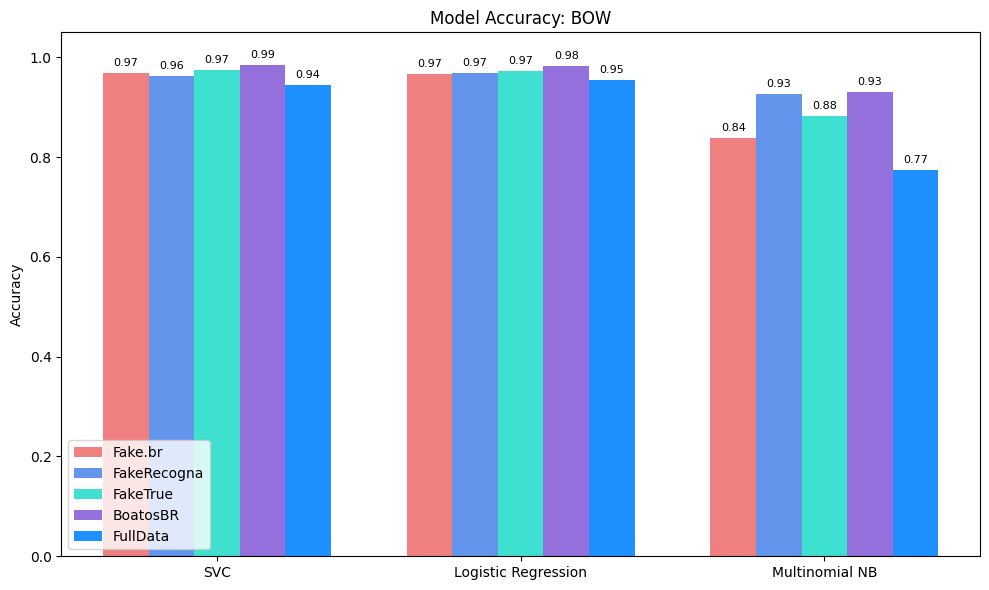

In [ ]:
plot_model_comparison(
    results,
    representation_name,
    model_names,
    dataset_labels=['Fake.br', 'FakeRecogna', 'FakeTrue', 'BoatosBR', 'FullData']
)

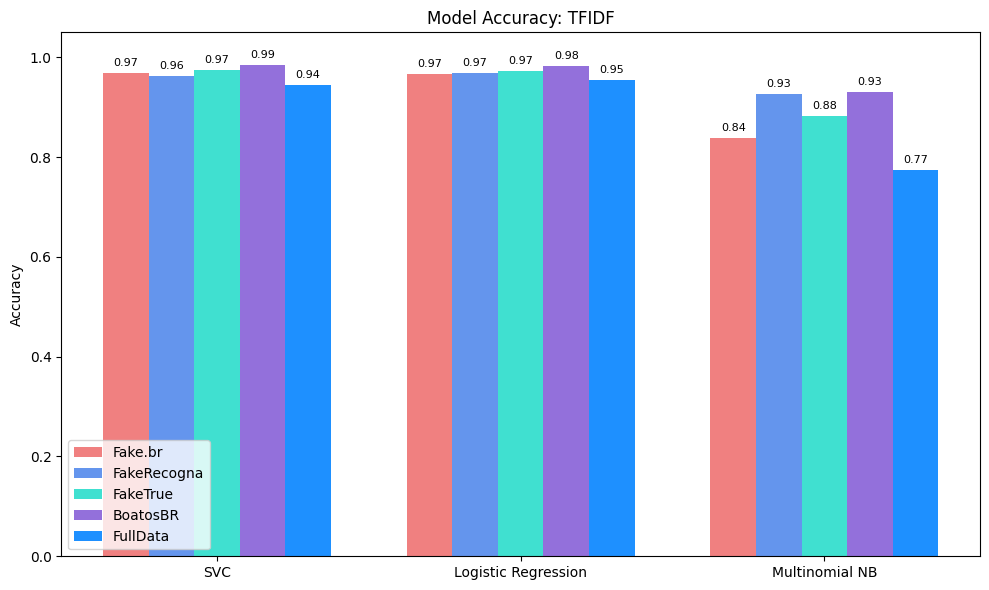

In [ ]:
representation_name = 'TFIDF'
model_names = ['SVC', 'Logistic Regression', 'Multinomial NB']

for dataframe in data:
    result = process_classification_methods(representation_name, dataframe)
    results.append(result)

plot_model_comparison(
    results,
    representation_name,
    model_names,
    dataset_labels=['Fake.br', 'FakeRecogna', 'FakeTrue', 'BoatosBR', 'FullData']
)

In [22]:
def plot_model_comparison(
    results,
    representation_name,
    model_names,
    dataset_labels=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    num_datasets = len(results)
    num_models = len(model_names)

    if dataset_labels is None:
        dataset_labels = [f'Dataset {i+1}' for i in range(num_datasets)]

    if len(dataset_labels) != num_datasets:
        raise ValueError("Number of dataset_labels must match number of datasets in results")

    # Bar positions
    x = np.arange(num_models)
    width = 0.8 / num_datasets  # make width fit all datasets nicely

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (dataset_result, label) in enumerate(zip(results, dataset_labels)):
        if len(dataset_result) != num_models:
            raise ValueError(f"Mismatch: result[{i}] has {len(dataset_result)} values, but there are {num_models} models.")

        ax.bar(x + (i - num_datasets // 2) * width, dataset_result, width, label=label)

    # Labels and formatting
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Model Accuracy: {representation_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1.05)
    ax.legend()

    # Add accuracy values above bars
    for bars in ax.containers:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


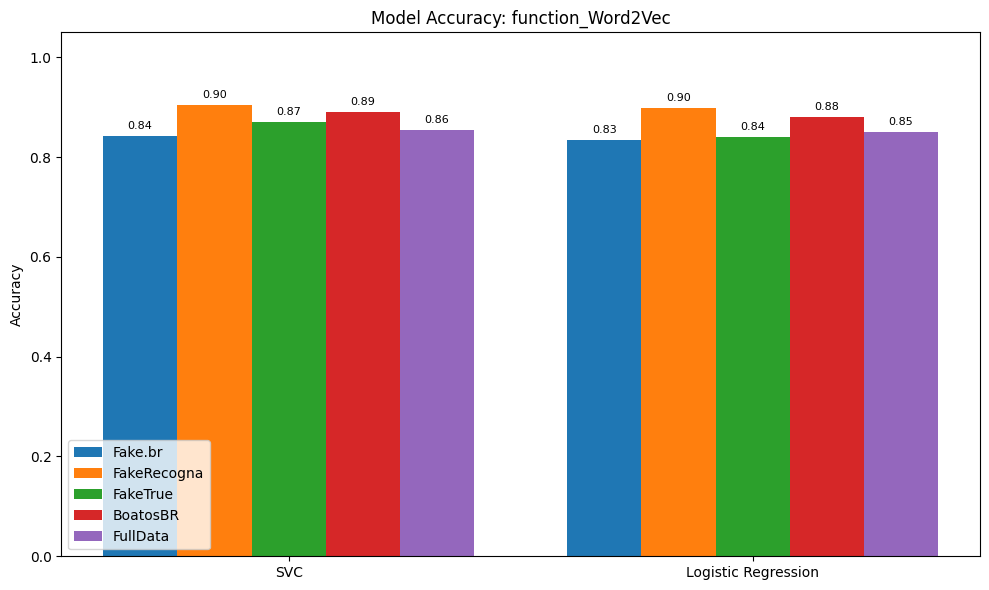

In [23]:
data1 = pd.concat([df_Fakebr_true, df_Fakebr_fake], ignore_index=True)
data2 = pd.concat([df_FakeRecogna_true, df_FakeRecogna_fake], ignore_index=True)
data3 = pd.concat([df_FakeTrue_true, df_FakeTrue_fake], ignore_index=True)
data4 = pd.concat([df_BoatosBR_true, df_BoatosBR_fake], ignore_index=True)
full_data = pd.concat([
    df_Fakebr_true,
    df_Fakebr_fake,
    df_FakeRecogna_true,
    df_FakeRecogna_fake,
    df_FakeTrue_true,
    df_FakeTrue_fake,
    df_BoatosBR_true,
    df_BoatosBR_fake
], ignore_index=True)
#25716

data = [data1, data2, data3, data4, full_data]
results = []

representation_name = 'function_Word2Vec'
model_names = ['SVC', 'Logistic Regression']

for dataframe in data:
    result = process_classification_methods(representation_name, dataframe)
    results.append(result)

plot_model_comparison(
    results,
    representation_name,
    model_names,
    dataset_labels=['Fake.br', 'FakeRecogna', 'FakeTrue', 'BoatosBR', 'FullData']
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Valores da matriz de confusão
y_true = ['spam'] * 50 + ['não-spam'] * 50
y_pred = ['spam'] * 45 + ['não-spam'] * 5 + ['spam'] * 10 + ['não-spam'] * 40

# Gerar a matriz de confusão
labels = ['spam', 'não-spam']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Classificação de Spam')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulação: tamanho do conjunto de dados (em milhares) vs. acurácia
data_sizes = np.array([1, 2, 4, 8, 16, 32, 64, 128])
accuracy = np.array([0.70, 0.75, 0.78, 0.81, 0.84, 0.86, 0.87, 0.88])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(data_sizes, accuracy, marker='o', linestyle='-', color='green')
plt.title('Impacto do Tamanho dos Dados na Acurácia do Modelo')
plt.xlabel('Tamanho do conjunto de treino (milhares de e-mails)')
plt.ylabel('Acurácia')
plt.grid(True)
plt.ylim(0.65, 0.90)
plt.xticks(data_sizes)
plt.tight_layout()
plt.show()


In [ ]:
'''
JOÃO JACÓ

- FAKE.BR

- BoW

- Máquina de Vetores de Suporte
- Naive Bayes
- Regressão Logística

- Análise de resultados: Comparou a eficiência dos três métodos de classificação entre si

Trabalhos futuros

1. Conjunto de testes balanceado: Em vez de usar um conjunto de testes des-
balanceado, considerar a criação de um conjunto de testes com 50% de notícias
verdadeiras e 50% de notícias falsas. Isso pode ajudar a reduzir possíveis vieses
dos modelos, em um cenário onde aleatoriamente foram escolhidas mais notícias
verdadeiras do que falsas por exemplo.
2. Variação nos Parâmetros de Aleatoriedade: Investigar diferentes fontes de
aleatoriedade, como o parâmetro random_state e os grupos de notícias selecionados
em métodos de validação cruzada, como o K-fold. Ajustar esses parâmetros pode
fornecer insights sobre a estabilidade e a generalização dos modelos em diferentes
cenários.
3. Exploração de Outros Métodos de Representação de Textos: Além da
abordagem de Bag of Words (BoW), considerar outros métodos de representação
de textos, como:
∙ TF-IDF (Term Frequency-Inverse Document Frequency): Que leva
em consideração não apenas a frequência das palavras em um documento, mas
também sua importância em relação ao corpus inteiro.
∙ Word Embeddings (Word2Vec, Doc2Vec), etc.: Técnicas que mapeiam
palavras em vetores de alta dimensionalidade, capturando relações semânticas
e contextuais entre as palavras.
∙ Modelos de Linguagem Pré-Treinados (BERT, GPT): Utilizar modelos
de linguagem pré-treinados e com grande confiabilidade para extrair represen-
tações ricas e contextualizadas das palavras

- procurar nova base de noticias
- Conjunto de testes balanceado (50%,50%)
- Variação nos Parâmetros de Aleatoriedade
- Exploração de Outros Métodos de Representação de Textos
'''

'''
ATILIO

- FAKE.BR + FakeRecogna

- Word2Vec - SKIPGRAM

- CNN (Rede Neural Convolucional)

- Análise de resultados: Comparou os resultados da CNN com um trabalho que utilizou RNAS do tipo LSTMs
'''

'''
- FAKE.BR
- BERT, DistilBERT e BERTimbau

'''

'''

FAKE.BR
FakeRecogna
FakeTrueBR


FACTCK.BR
FactCenter -

– Naive Bayes (NB) [19]
– Support Vector Machines (SVM) [9]
– Convolutional Neural Networks (CNN): [11,13]

– Multi-Layer Perceptron (MLP) [2]
– Optimum-Path Forest (OPF) [24,23]
– Random Forest (RF) [10]

'''

'''
LARISSA

FAKE.BR + FakeRecogna + FakeTrueBR - Conjunto de testes balanceado (50%,50%)

TF-IDF (Term Frequency-Inverse Document Frequency)
Word2Vec

- Máquina de Vetores de Suporte
- Naive Bayes
- Regressão Logística

- CNN (Rede Neural Convolucional)
'''


